## Final Exam WQD 7005 Data Mining 
## Question 5

### Name: Nurullainy binti Mat Rashid                   
### ID :  17036591

### Topic: Density-Based Clustering of Internet Movie Database (IMDb)

The objectives are to implement density-based clustering using data from IMDb. The data was collected from the following website : https://www.imdb.com/search/title/?year=2017


In order to achieve the task, I will be going to cover the following steps:

    1) Importing required libraries
    2) Load the dataset (Question 1)  into a DataFrame object
    3) Visualize the data, use only two of these attributes at the time
    4) You may need to normalise the attribute if necessary
    5) Show positive correlation between attributes if necessary
    6) Construct a density-based clustering model and extract cluster labels and outliers to plot your results


### 1) Importing required libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.neighbors import NearestNeighbors

import math

### 2) Load the dataset (Question 1)  into a DataFrame object

In [2]:
# Load dataset

df = pd.read_csv('movies_imdb_preprocessed.csv')
df.head()

,movie_name,year_released,runtime_in_min,genre,revenues,imdb_rating,user_votes,director,actor
0,Gladiator,2000,155,"Action, Adventure, Drama",187705427,8.5,1295546,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen..."
1,Memento,2000,113,"Mystery, Thriller",25544867,8.4,1088700,Christopher Nolan,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano, ..."
2,Snatch,2000,104,"Comedy, Crime",30328156,8.3,760646,Guy Ritchie,"Jason Statham, Brad Pitt, Benicio Del Toro, De..."
3,Requiem for a Dream,2000,102,Drama,3635482,8.3,742193,Darren Aronofsky,"Ellen Burstyn, Jared Leto, Jennifer Connelly, ..."
4,X-Men,2000,104,"Action, Adventure, Sci-Fi",157299717,7.4,558716,Bryan Singer,"Patrick Stewart, Hugh Jackman, Ian McKellen, F..."


In [3]:
df.isnull().sum()

movie_name         0
year_released      0
runtime_in_min     0
genre              0
revenues           0
imdb_rating        0
user_votes         0
director          78
actor             78
dtype: int64

We can see that there are a number of empty strings in `director` and `actor` column. Replace them with `nan` and typecast it into the correct string data type.

In [4]:
df['director'] = df['director'].replace('', np.nan).astype(str)
df['actor'] = df['actor'].replace('', np.nan).astype(str)

In [5]:
df.shape

(894, 9)

### 3) Visualize the data, use only two of these attributes at the time

Visualisation is a great way to spot data problems within the dataset. Again, we will use `seaborn` and `matplotlib` for that purpose. Plot the distribution of the variables using `distplot`.

In [6]:
# Change million notation for data visualization

df_revenue = df['revenues'].div(1000000).to_frame('col') # Change to Million notation
df_revenue.shape

df['revenues_in_mil'] = df_revenue['col']

df['revenues_in_mil'] = df['revenues_in_mil'].round(0).astype(int)

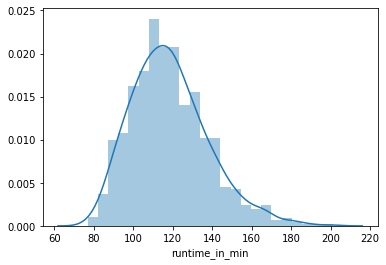

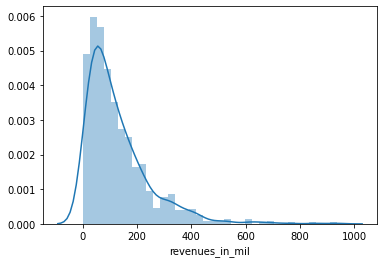

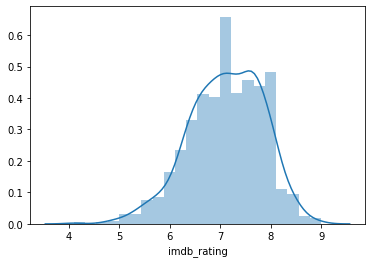

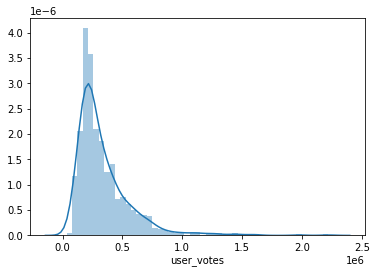

In [7]:
# Distribution of runtime
runtime_dist = sns.distplot(df['runtime_in_min'].dropna())
plt.show()

# Distribution of revenues
revenue_dist = sns.distplot(df['revenues_in_mil'].dropna())
plt.show()

# Distribution of imdb_rating
rating_dist = sns.distplot(df['imdb_rating'].dropna())
plt.show()

# Distribution of user_votes
votes_dist = sns.distplot(df['user_votes'].dropna())
plt.show()

The above attributes showed normal distribution. We also could "zoom in" on the distribution by increasing the number of bins. View revenues distribution with more number of bin.

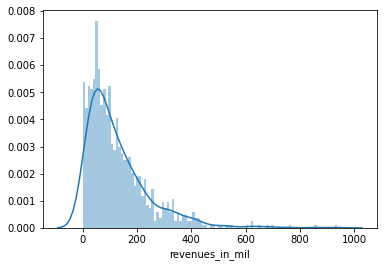

In [8]:
# Distribution of imdb ratings, with increased number of bins. More bins = more specific distplot.

rating_dist = sns.distplot(df['revenues_in_mil'].dropna(), bins=100)
plt.show()

#### Use only two of these attributes at the time

There are a number of good grouping objectives that can be applied in this dataset. I could cluster them based on runtime, revenue, user votes or imdb ratings. For this case, I would like to focus on revenues and see the combination from other attributes namely imdb_rating, user_votes, and runtime

#### Revenue and IMDb Rating Clustering

In [9]:
revenue_rating = df[['revenues','imdb_rating',]]

revenue_rating.head()

,revenues,imdb_rating
0,187705427,8.5
1,25544867,8.4
2,30328156,8.3
3,3635482,8.3
4,157299717,7.4


### 4) You may need to normalise the attribute if necessary

Because some of the values are in thousands and millions, I need to normalize each attribute by scaling it to 0 mean and unit variance.

In [10]:
data = revenue_rating.as_matrix().astype("float32", copy = False)

stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### 5) Show positive correlation between attributes if necessary

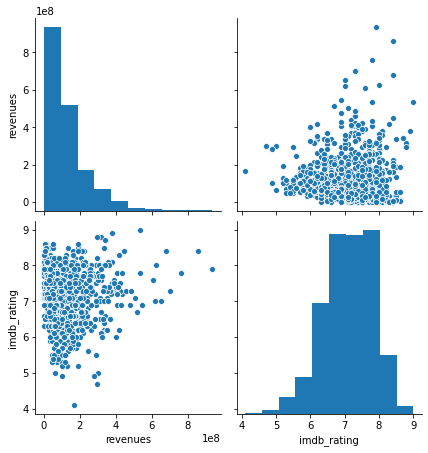

In [11]:
# Pairplot the data distribution.

fg1 = sns.pairplot(revenue_rating, height=3)
plt.show()

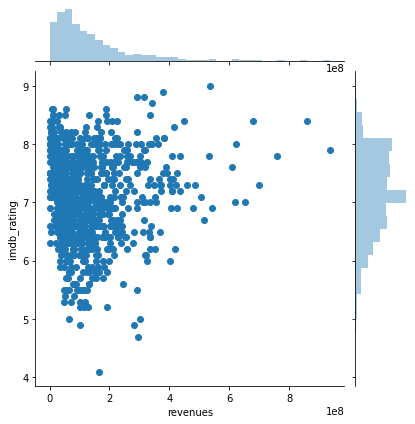

In [12]:
# Another data visualization using jointplot

sns.jointplot(x="revenues", y="imdb_rating", data=revenue_rating)

A positive correlation is a relationship between two variables in which both variables move in the same direction. Therefore, when one variable increases as the other variable increases, or one variable decreases while the other decreases. In this case, the above plot shows there is positive correlation between IMDb rating and revenue generated from each movie. Movie with high revenue has high imdb rating at the same time.

### 6) Construct a Density-Based Clustering model and extract cluster labels and outliers to plot your results

`eps` is the maximum distance between two points. It is this distance that the algorithm uses to decide on whether to group the two points together. 

`min_samples` is minimum number of neighbors a given point should have in order to be classified as a core point.

The algorithm will starts with an arbitrary point (p point) and retrieve all points density-reachable from the p point with respect to `eps` and `min_samples` sets in the algorithm. If p point is a core point, it will result a cluster and if p point is a border point, no points are density-reachable from p point. Then the model visits the next point in the database.

DBSCAN works by determining whether the minimum number of points are close enough to one another to be considered part of a single cluster or otherwise. In simpler word, DBSCAN finds density-connected regions. 

#### Construct a Density-Based Clustering model using DBSCAN function with eps = 0.5

In [13]:
# Construct a density-based clustering model 

db = DBSCAN(eps=0.5, min_samples=10).fit(data) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True

In [14]:
# Extract cluster labels and outliers

labels = db.labels_ 
revenue_rating['Cluster_ID'] = labels

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Number of Cluster: 2
Cluster membership
 0    865
-1     29
Name: Cluster_ID, dtype: int64


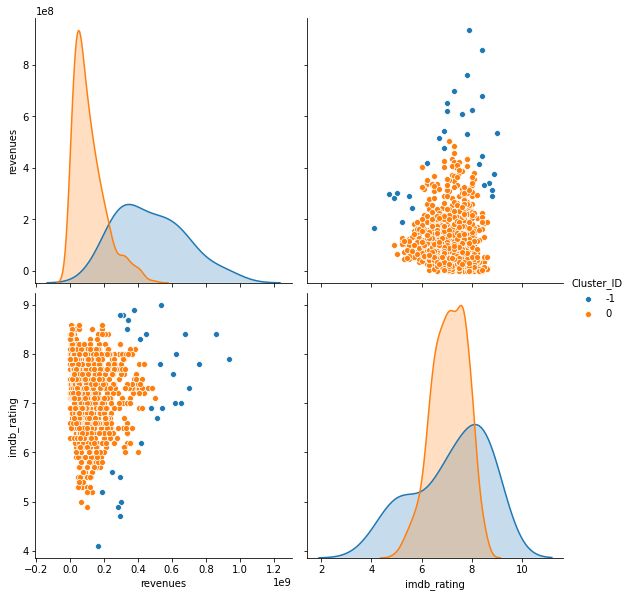

In [15]:
# Number of records are in each cluster
print("Number of Cluster:", len(revenue_rating['Cluster_ID'].value_counts()))
print("Cluster membership")
print(revenue_rating['Cluster_ID'].value_counts())

# Pairplot the cluster distribution.
cluster_db = sns.pairplot(revenue_rating, hue='Cluster_ID', height=4)
plt.show()

Number of cluster identified by the model is 2

#### Finding optimal epsilon value using k-distance

There is no general way of choosing minPts. However, a low minPts means it will build more clusters from noise, hence I maintain min_sample as 10.

I will calculate the distances of every point to its closest neighbour (k-distances) using the `NearestNeighbors` from `sklearn` library. The algorithm works by computing the distance between every point and all other points. These `k-distances` are then plotted in ascending order. The point where an elbow like bend corresponds to the optimal `eps` value. 

`metric` is the metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).

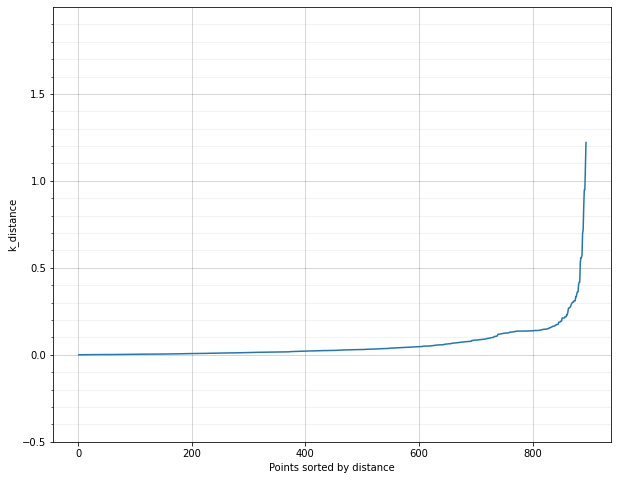

In [16]:
# Find k-distance and plot in ascending order

ns = 2
nbrs = NearestNeighbors(n_neighbors=ns, metric='euclidean').fit(data)
distances, indices = nbrs.kneighbors(data)
k_distance = sorted(distances[:,ns-1], reverse=False)    # sort the distance


fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(list(range(1,len(data)+1)), k_distance)
plt.axis([None, None, -0.5, 2])
plt.xlabel ('Points sorted by distance')
plt.ylabel ('k_distance')

major_ticks = np.arange(-0.5, 2, 0.5)
minor_ticks = np.arange(-0.5, 2, 0.1)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.2, color='black')

The above graph shows a sharp change in the distance occurs at k_distance=0.15, and thus this point serves as a threshold.  0.15 is the optimal epsilon value for this data.

#### Construct a Density-Based Clustering model with optimal epsilon value, eps=0.15

In [17]:
# Construct a density-based clustering model

db = DBSCAN(eps=0.15, min_samples=10).fit(data) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True

In [18]:
# Extract cluster labels and outliers

labels = db.labels_ 
revenue_rating['Cluster_ID'] = labels

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Number of Cluster: 5
Cluster membership
 0    514
-1    337
 1     25
 2     11
 3      7
Name: Cluster_ID, dtype: int64


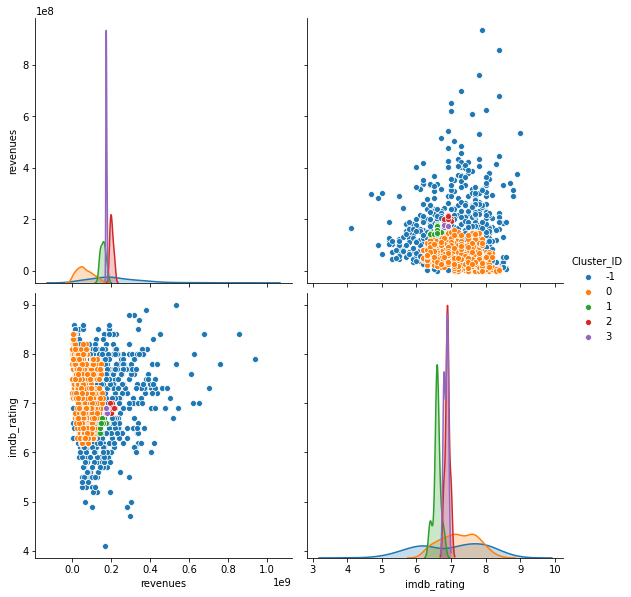

In [19]:
# Number of records are in each cluster
print("Number of Cluster:", len(revenue_rating['Cluster_ID'].value_counts()))
print("Cluster membership")
print(revenue_rating['Cluster_ID'].value_counts())

# Pairplot the cluster distribution.
cluster_db = sns.pairplot(revenue_rating, hue='Cluster_ID', height=4)
plt.show()

Based on optimal epsilon value, number of cluster identified by the model is 5. Unlike k-means, DBSCAN will figure out the number of clusters in the dataset. DBSCAN is very sensitive to scale since epsilon is a fixed value for the maximum distance between two points. Different epsilon value yield different number of cluster. In this case, eps= 0.5 yield 2 clusters whereas if eps=0.15, the output is 5 clusters